In [149]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Load all the spike and value data

In [2]:
def load_nef_values(load=True):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        values['dvs'] = np.abs(values['va'] - values['vb'])
        values['dva'] = np.abs(values['vl'] - values['vr'])
        values['dvt'] = values['dvs'] + values['dva']
        # values.rename(columns={'wab': 'w'}, inplace=True)
        # values = values.dropna()
        values = values.drop(columns='block_type')
        values = values.drop(columns='before')
        values = values.drop(columns='after')
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [7]:
def load_rl_values(load=True):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            print(block, trial)
                            # pass
        values = pd.concat(dfs, ignore_index=True)
        # values = values.drop(columns='omega_BlockMean')
        # values = values.dropna()
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [8]:
def load_nef_spikes(load=True):
    if load:
        with open('data/nef_spikes_condensed.pkl', 'rb') as file:
            nef_spikes = pickle.load(file)
    else:
        nef_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            nef_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                nef_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    nef_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        v = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['v'].sum(axis=0)  # sum over time
                        w = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['w'].sum(axis=0)  # sum over time
                        a = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['a'].sum(axis=0)  # sum over time
                        vwa = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa'].sum(axis=0)  # sum over time
                        evc = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['evc'].sum(axis=0)  # sum over time
                        ewt = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['ewt'].sum(axis=0)  # sum over time
                        # combined = np.concatenate([v,w,a], axis=0)
                        combined = np.concatenate([v,w,a,vwa,evc,ewt], axis=0)
                        nef_spikes[monkey][session][block][trial] = combined
        filename = "nef_spikes_condensed"
        with open(f'data/{filename}.pkl', 'wb') as f:
            pickle.dump(nef_spikes, f)
    return nef_spikes

In [16]:
def load_monkey_spikes(load=True):
    if load:
        with open('data/monkey_spikes_condensed.pkl', 'rb') as file:
            emp_spikes = pickle.load(file)
    else:
        emp_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            emp_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                emp_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    emp_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        try:
                            file = f"data/emp_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz"
                            emp_spikes[monkey][session][block][trial] = np.load(file)['spikes']
                        except:
                            print(monkey, session, block, trial)
                            # pass
        with open('data/monkey_spikes_condensed.pkl', 'wb') as f:
            pickle.dump(emp_spikes, f)
    return emp_spikes

In [ ]:
nef_values = load_nef_values(load=False)
rl_values = load_rl_values(load=False)

In [28]:
nef_spikes = load_nef_spikes(load=False)
monkey_spikes = load_monkey_spikes(load=False)

# 1. Can we predict (RL/NEF) values using (Monkey/Model) spikes using linear regression

In [104]:
def regress_spikes_values(spikes, values, model_type='ridge', preprocess=None, cross_validate=True, alpha=1.0, n_folds=10, n_pca=20):
    dfs_error = []
    dfs_trial = []
    variables = values.columns[4:]
    columns_error = ['monkey', 'session', 'variable', 'r2']
    columns_trial = ['monkey', 'session', 'block', 'trial', 'var', 'true_value', 'pred_value']
    regression_dict = {}
    for monkey in ['V', 'W']:
        regression_dict[monkey] = {}
        for session in [0,1,2,3]:
            print(monkey, session)
            included = []
            regression_dict[monkey][session] = {}
            for variable in variables:
                X = []
                Y = []
                for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        try:
                            x = spikes[monkey][session][block][trial]
                            y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()
                            X.append(x)
                            Y.append(y)
                            included.append([block, trial])
                        except:
                            pass
                X, Y = np.array(X), np.array(Y).ravel()
                if model_type == 'linear':
                    model = LinearRegression()
                elif model_type == 'ridge':
                    model = Ridge(alpha=alpha)
                elif model_type == 'ridgecv':
                    model = RidgeCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
                elif model_type == 'lassocv':
                    model = LassoCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
                elif model_type == 'elasticnetcv':
                    model = ElasticNetCV(l1_ratio=[.1, .5, .9, 1.0], alphas=np.logspace(-3, 1, 10), cv=n_folds)
                if preprocess=='standard':
                    X = StandardScaler().fit_transform(X)
                elif preprocess=='pca':
                    model = make_pipeline(PCA(n_components=n_pca), model)
                if cross_validate:
                    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
                    scores = []
                    for train_idx, test_idx in cv.split(X):
                        model.fit(X[train_idx], Y[train_idx])
                        Y_pred = model.predict(X[test_idx])
                        scores.append(r2_score(Y[test_idx], Y_pred))
                    mean_r2 = np.mean(scores)
                    model.fit(X, Y)
                else:
                    model.fit(X, Y)
                    Y_pred = model.predict(X)
                    mean_r2 = r2_score(Y, Y_pred)
                regression_dict[monkey][session][variable] = model
                dfs_error.append(pd.DataFrame([[monkey, session, variable, mean_r2]], columns=columns_error))
                print(variable, mean_r2)
                for i in range(len(X)):
                    x, y = X[i], Y[i]
                    block, trial = included[i][0], included[i][1]
                    y_pred = regression_dict[monkey][session][variable].predict(x.reshape(-1,1).T)[0]
                    dfs_trial.append(pd.DataFrame([[monkey, session, block, trial, variable, y, y_pred]], columns=columns_trial))
    data_error = pd.concat(dfs_error, ignore_index=True)
    data_trial = pd.concat(dfs_trial, ignore_index=True)
    return data_error, data_trial

In [ ]:
nef_error, nef_trial = regress_spikes_values(nef_spikes, nef_values, model_type='ridge')
nef_error.to_pickle("data/nef_error.pkl")
nef_trial.to_pickle("data/nef_trial.pkl")
# nef_error = pd.read_pickle("data/nef_error.pkl")
# nef_trial = pd.read_pickle("data/nef_trial.pkl")

/tmp/ipykernel_1314961/1869509350.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(nef_error.query("variable==@nef_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)


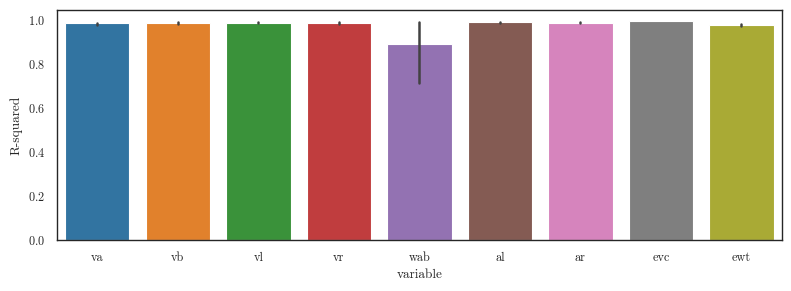

In [107]:
nef_vars = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(nef_error.query("variable==@nef_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="R-squared")
fig.savefig("plots/nef_spikes_nef_values_regression_ridge.jpg", dpi=600)

### Figure 1.1
Linear regression on the model spikes can recreate the "ground truth" values for the NEF model almost perfectly. This isn't surprising, since these "ground truth" values are obtained using another linear decoding method (based on the NEF) from the model spikes

In [ ]:
monkey_error, monkey_trial = regress_spikes_values(monkey_spikes, rl_values, model_type='elasticnetcv')
monkey_error.to_pickle("data/monkey_error.pkl")
monkey_trial.to_pickle("data/monkey_trial.pkl")
# monkey_error = pd.read_pickle("data/monkey_error.pkl")
# monkey_trial = pd.read_pickle("data/monkey_trial.pkl")

/tmp/ipykernel_1314961/3473484811.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_error.query("variable==@rl_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)


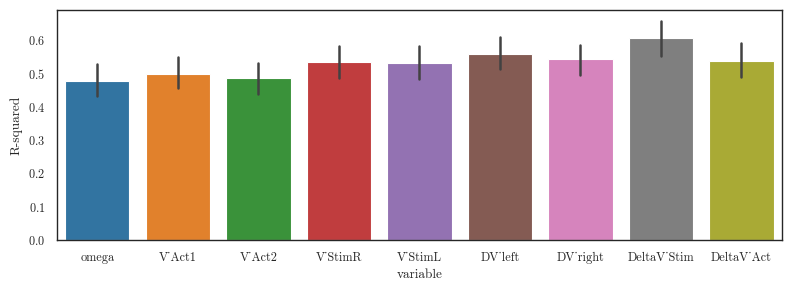

In [103]:
rl_vars = ['V_StimL', 'V_StimR', 'DeltaV_Stim', 'V_Act1', 'V_Act2', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(monkey_error.query("variable==@rl_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="R-squared")
fig.savefig("plots/monkey_spikes_rl_values_regression.jpg", dpi=600)

### Figure 1.2

Linear regression on the monkey spikes can recreate the "ground truth" values from the RL model fairly well. Previously, I had been reporting errors without cross-validation, but these results are $R^2$ values with 10-fold cross validation. Initially, my attempts at decoding monkey spikes and calculating cross-validated $R^2$ were quite bad (0.1-0.2). I found that two things significantly improved the fits:

- Preprocessing the spikes
  - For each neuron's activity, removing it's mean and scaling to unit variance, or
  - Applying PCA to the activity matrix
 - Using more complicated regression models with variable degrees of regularization
   - LassoCV
   - ElasticNetCV

/tmp/ipykernel_1314961/3707622269.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_1314961/3707622269.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


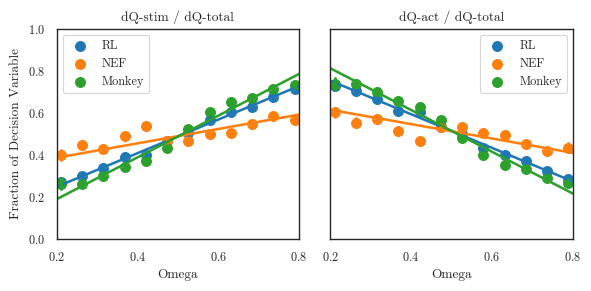

In [24]:
nef_wab = nef_trial.query("var=='wab'")['true_value'].to_numpy()
# nef_wlr = nef_trial.query("var=='wlr'")['true_value'].to_numpy()
nef_dvs = np.abs(nef_trial.query("var=='va'")['true_value'].to_numpy() - nef_trial.query("var=='vb'")['true_value'].to_numpy())
nef_dva = np.abs(nef_trial.query("var=='vl'")['true_value'].to_numpy() - nef_trial.query("var=='vr'")['true_value'].to_numpy())
nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
nef_p_act = nef_dva / (nef_dvs + nef_dva)

rl_w = monkey_trial.query("var=='omega'")['true_value'].to_numpy()
rl_dvs = np.abs(monkey_trial.query("var=='V_StimL'")['true_value'].to_numpy() - monkey_trial.query("var=='V_StimR'")['true_value'].to_numpy())
rl_dva = np.abs(monkey_trial.query("var=='V_Act1'")['true_value'].to_numpy() - monkey_trial.query("var=='V_Act2'")['true_value'].to_numpy())
rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
rl_p_act = rl_dva / (rl_dvs + rl_dva)

monkey_w = monkey_trial.query("var=='omega'")['pred_value'].to_numpy()
monkey_dvs = np.abs(monkey_trial.query("var=='V_StimL'")['pred_value'].to_numpy() - monkey_trial.query("var=='V_StimR'")['pred_value'].to_numpy())
monkey_dva = np.abs(monkey_trial.query("var=='V_Act1'")['pred_value'].to_numpy() - monkey_trial.query("var=='V_Act2'")['pred_value'].to_numpy())
monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)

w_bins = np.linspace(0, 1, 20)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], label='RL')
sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], label='Monkey')
sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], label='RL')
sns.regplot(x=nef_wab, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], label='Monkey')
axes[0].legend()
axes[1].legend()
axes[0].set(ylabel='Fraction of Decision Variable', title="dQ-stim / dQ-total", xlim=(0.2, 0.8), ylim=(0, 1), xlabel='Omega')
axes[1].set(title="dQ-act / dQ-total", xlabel='Omega')
plt.tight_layout()
fig.savefig("plots/fraction_DV_vs_omega.jpg", dpi=600)

### Figure 1.3
I took the values decoded from the monkey/model spikes, then plotted them as a function of each other. The goal was to show that $\omega$ has the expected effect of arbitrating $\Delta Q_{stim}$ versus $\Delta Q_{act}$. This plot shows each decision system contributes to $\Delta Q_{total}$ (that is, $\Delta DV$), expressed as a fraction. As expected, when $\omega$ is large, $stim$ contributes more, and when $\omega$ is small, $act$ contributes more. Note that the NEF data are noisy in this plot, but I expect the relationship to be cleaner if I fit the NEF models to the monkey data more carefully.

# 2. How do spikes correlate with represented variables on a trial-by-trial basis?
Representational Similarity Analysis between intertrial spike changes and intertrial value changes, for different combinations of value variables

In [118]:
def clean_xy(x, y):
    x = np.array(x) # shape: (n_trials, n_neurons)
    y = np.array(y) # shape: (n_trials, n_values)
    if y.shape[1] > 1:
        row_std = np.std(y, axis=1)
        keep = row_std > 1e-6
        x = x[keep, :]  # Remove rows with low variance
        y = y[keep, :]  # Remove rows with low variance
    return x, y

def flatten_rdm(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

def RSA(monkey, session, spikes, values, variables, preprocess=True, metric='correlation'):
    X_spikes = []
    Y_values = []
    for block in values.query("monkey==@monkey & session==@session")['block'].unique():
        for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
            try:
                x = spikes[monkey][session][block][trial]
                y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variables].values.flatten()
                X_spikes.append(x.astype(float))
                Y_values.append(y.astype(float))
            except:
                # print(f"skipping {monkey} {session} {block} {trial}")
                pass
    X_spikes, Y_values = clean_xy(X_spikes, Y_values)
    if preprocess:
        X_spikes = StandardScaler().fit_transform(X_spikes)
    X_rdm = squareform(pdist(X_spikes, metric=metric))  # shape: (n_trials, n_trials)
    Y_rdm = squareform(pdist(Y_values, metric=metric))  # shape: (n_trials, n_trials)
    X_vec = flatten_rdm(X_rdm)
    Y_vec = flatten_rdm(Y_rdm)
    rsa_score, pval = spearmanr(X_vec, Y_vec)  # Spearman correlation
    # print(f"monkey {monkey}, session {session}, Overall RSA Spearman r = {rsa_score:.3f}, p = {pval:.3e}")
    return rsa_score, pval

def RSA_vs_variables(spikes, values, variables_list, preprocess=True):
    dfs = []
    columns = ['monkey', 'session', 'variables', 'score', 'p']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            for variables in variables_list:
                score, p = RSA(monkey, session, spikes, values, variables, preprocess)
                dfs.append(pd.DataFrame([[monkey, session, variables, score, p]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

def RSA_by_spikes(nef_spikes, monkey_spikes, variables_list, preprocess=True):
    dfs = []
    columns = ['monkey', 'session', 'score', 'p']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            S1 = []
            S2 = []
            for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    try:
                        S1.append(nef_spikes[monkey][session][block][trial])
                        S2.append(monkey_spikes[monkey][session][block][trial])
                    except:
                        print(f"skipping {monkey} {session} {block} {trial}")
            S1, S2 = np.array(S1), np.array(S2)
            if preprocess:
                S1 = StandardScaler().fit_transform(S1)
                S2 = StandardScaler().fit_transform(S2)
            S1_rdm = squareform(pdist(S1, metric=metric))  # shape: (n_trials, n_trials)
            S2_rdm = squareform(pdist(S2, metric=metric))  # shape: (n_trials, n_trials)
            S1_vec = flatten_rdm(X_rdm)
            S2_vec = flatten_rdm(Y_rdm)
            score, p = spearmanr(S1_vec, S2_vec)  # Spearman correlation
            dfs.append(pd.DataFrame([[monkey, session, score, p]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

In [ ]:
a = ['V_StimL', 'V_StimR']
b = ['V_Act1', 'V_Act2']
c = ['V_Act1', 'V_Act2']
d = ['DeltaV_Act', 'DeltaV_Stim']
e = ['DV_left', 'DV_right', 'omega']
f = ['DeltaV_Act', 'DeltaV_Stim', 'omega']
g = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2']
h = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'omega']
variables_list = [a,b,c,d,e,f,g,h]
monkey_rsa = RSA_vs_variables(monkey_spikes, rl_values, variables_list, preprocess=True)

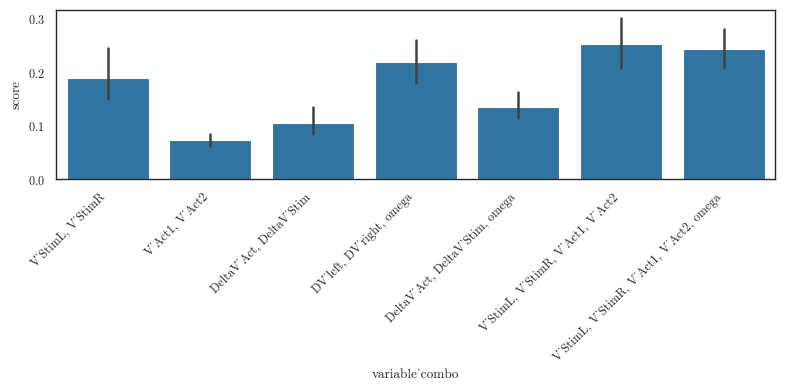

In [152]:
monkey_rsa['variable_combo'] = monkey_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(monkey_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
fig.savefig("plots/monkey_spikes_RSA.jpg", dpi=600)

### Figure 2.1
There seems to be a moderate correlation between the trial-to-trial variance in the monkey spike data, and the trial-to-trial variance in the variables from the RL model. In general, including more variables explains more of the spike variance. Some variables seem to contribute more to this variance than others, suggesting that changes in neural activity may predominantly reflect changes in those variables?

In [180]:
a = ['al', 'ar']
# b = ['dvs', 'dva']
c = ['al', 'ar', 'wab']
d = ['evc', 'ewt']
e = ['va', 'vb', 'vl', 'vr']
f = ['va', 'vb', 'vl', 'vr', 'wab']
g = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar']
h = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
variables_list = [a,c,d,e,f,g,h]
nef_rsa = RSA_vs_variables(nef_spikes, nef_values, variables_list, preprocess=True)

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


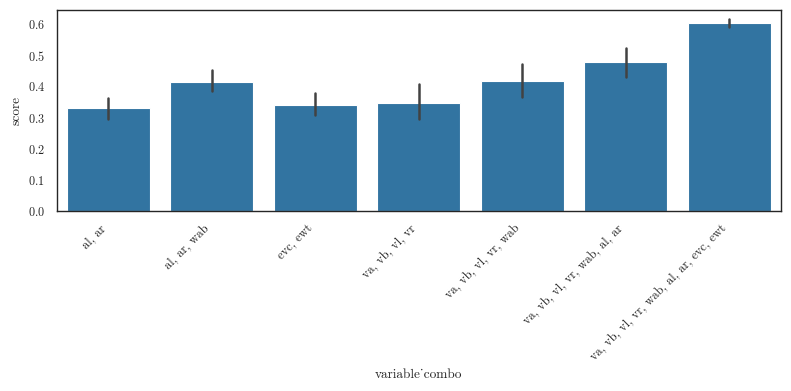

In [256]:
nef_rsa['variable_combo'] = nef_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(nef_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
fig.savefig("plots/NEF_RSA.jpg", dpi=600)

### Figure 2.2
There is a stronger correlation between model spike variance and model variables. Including more variables significantly improves the correlation. However, the correlation with RSA is far less strong than the $R^2$ analysis in Fig 1. This suggests to me that there are limits to how much we can infer about representations with this method, even when we know (through NEF modeling and other anslyses) that the representations are a certain way.

# 3. Can we infer anything about representations using the magnitudes of regression coefficients?

In [157]:
def regression_weights(spikes, values, spike_type, model_type='lassocv', preprocess="standard", alpha=1.0, n_folds=3, n_pca=20):
    dfs = []
    variables = values.columns[4:]
    columns = ['monkey', 'session', 'neuron', 'population', 'variable', 'weight']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            X = []
            Y = []
            for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    try:
                        X.append(spikes[monkey][session][block][trial])
                        y = []
                        for variable in variables:
                            y.append(values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()[0])
                        Y.append(y)
                    except:
                        pass
            X, Y = np.array(X), np.array(Y)
            n_neurons = X.shape[1]
            print("fitting model")
            if model_type == 'linear':
                model = LinearRegression()
            elif model_type == 'ridge':
                model = Ridge(alpha=alpha)
            elif model_type == 'ridgecv':
                model = RidgeCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
            elif model_type == 'lassocv':
                # model = LassoCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
                model = MultiOutputRegressor(LassoCV(alphas=np.logspace(-2, 1, 10), cv=n_folds, max_iter=10000))
                model = MultiTaskLassoCV(alphas=np.logspace(-2, 1, 10), cv=n_folds, max_iter=5000, n_jobs=-1)
            elif model_type == 'elasticnetcv':
                # model = ElasticNetCV(l1_ratio=[.1, .5, .9, 1.0], alphas=np.logspace(-3, 1, 10), cv=n_folds)
                model = MultiTaskElasticNetCV(alphas=np.logspace(-2, 1, 10), l1_ratio=0.5, cv=n_folds, n_jobs=-1)
            if preprocess=='standard':
                X = StandardScaler().fit_transform(X)
            elif preprocess=='pca':
                model = make_pipeline(PCA(n_components=n_pca), model)
            model.fit(X, Y)
            weights = model.coef_.T
            sqr_weights = np.square(weights)
            for v, variable in enumerate(variables):
                # print(v, variable)
                df = pd.DataFrame(columns=columns)
                df['monkey'] = [monkey for _ in range(n_neurons)]
                df['session'] = [session for _ in range(n_neurons)]
                df['neuron'] = [n for n in range(n_neurons)]
                if spike_type=='nef':
                    pops = []
                    for pop in ['v', 'w', 'a', 'vwa', 'evc', 'ewt']:
                        pops.extend([pop for _ in range(int(n_neurons/6))])
                    df['population'] = pops
                else:
                    df['population'] = ['all' for n in range(n_neurons)]
                df['variable'] = [variable for _ in range(n_neurons)]
                df['weight'] = sqr_weights[:,v]
                dfs.append(df)
    neuron_weights = pd.concat(dfs, ignore_index=True)
    return neuron_weights

In [ ]:
nef_weights = regression_weights(nef_spikes, nef_values, spike_type='nef')
# nef_weights.to_pickle("data/nef_regression_weights.pkl")

In [166]:
nef_weights = nef_weights[nef_weights['variable'] != 'acc']
nef_weights = nef_weights[nef_weights['variable'] != 'dvs']
nef_weights = nef_weights[nef_weights['variable'] != 'dva']
nef_weights = nef_weights[nef_weights['variable'] != 'dvt']

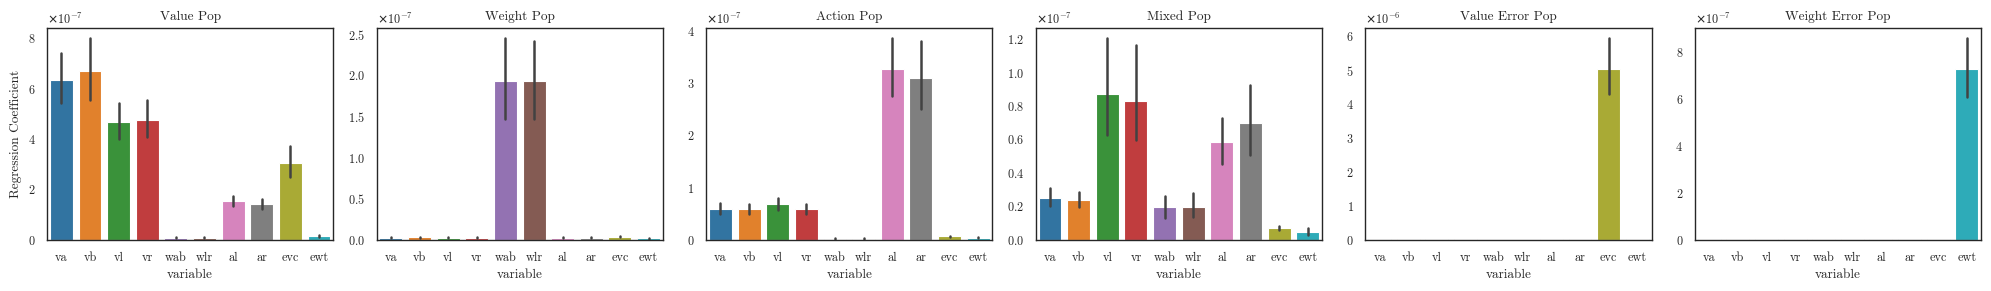

In [174]:
populations = nef_weights['population'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(20, 3), sharey=False)
for p, population in enumerate(populations):
    sns.barplot(nef_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
    axes[p].set(title=population)
axes[0].set(title="Value Pop", ylabel='Regression Coefficient')
axes[1].set(title="Weight Pop", ylabel=None)
axes[2].set(title="Action Pop", ylabel=None)
axes[3].set(title="Mixed Pop", ylabel=None)
axes[4].set(title="Value Error Pop", ylabel=None)
axes[5].set(title="Weight Error Pop", ylabel=None)
fig.tight_layout()
fig.savefig("plots/nef_regression_weights.jpg", dpi=600)

### Figure 3.1
With the NEF model, we divide neurons into populations, and give each population a different set of variables to represent. Looking at the regression weights for each population, it is fairly easy to infer what those represented variables are. However, populations that represent value variables will also seem to represent total DV variables to some degree, and visa versa. Error populations have very distinct representations.

In [158]:
monkey_weights = regression_weights(monkey_spikes, rl_values, spike_type='monkey')
monkey_weights.to_pickle("data/monkey_regression_weights.pkl")

/tmp/ipykernel_1314961/3051738099.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette)


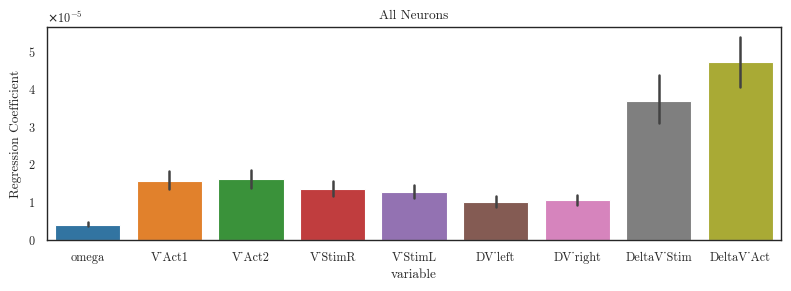

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=False)
sns.barplot(monkey_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette)
axes.set(title="All Neurons", ylabel='Regression Coefficient')
fig.tight_layout()
fig.savefig("plots/monkey_regression_weights.jpg", dpi=600)

### Figure 3.2
It would be interesting to group monkey neurons based on their anatomical location (e.g., into different PFC regions), then see if those regions had significantly different weights, like in Figure 3.1. But I'll need some help from @Jae to do this.

# 4. If we did't know anything about population boundaries, could we infer those boundaries based on clustering of neural representations?
(work in progress)

In [237]:
def cluster_weights(neuron_weights, n_clusters=8):
    pre_columns = ['monkey', 'session', 'neuron', 'population']
    tuning_df = neuron_weights.pivot_table(index=pre_columns, columns='variable', values='weight', aggfunc='first').dropna()
    tuning_matrix = tuning_df.to_numpy()
    tuning_matrix_scaled = StandardScaler().fit_transform(tuning_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(tuning_matrix_scaled)
    tuning_df['cluster'] = cluster_labels

    abs_weights = np.abs(tuning_df.drop(columns='cluster'))
    dominant_var = abs_weights.idxmax(axis=1)
    tuning_df['dominant_variable'] = dominant_var

    pca = PCA(n_components=2)
    proj_2d = pca.fit_transform(tuning_matrix_scaled)
    
    return proj_2d, tuning_df

In [253]:
nef_weights = pd.read_pickle("data/nef_regression_weights.pkl")
# nef_weights = nef_weights[nef_weights['variable'] != 'evc']
# nef_weights = nef_weights[nef_weights['variable'] != 'ewt']
nef_weights = nef_weights[nef_weights['variable'] != 'acc']
nef_weights = nef_weights[nef_weights['variable'] != 'dvs']
nef_weights = nef_weights[nef_weights['variable'] != 'dva']
nef_weights = nef_weights[nef_weights['variable'] != 'dvt']
nef_pca, nef_tuning = cluster_weights(nef_weights, n_clusters=6)

/tmp/ipykernel_1314961/3318280373.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=nef_pca[:, 0], y=nef_pca[:, 1], hue=nef_tuning['cluster'], palette=palette, ax=ax)


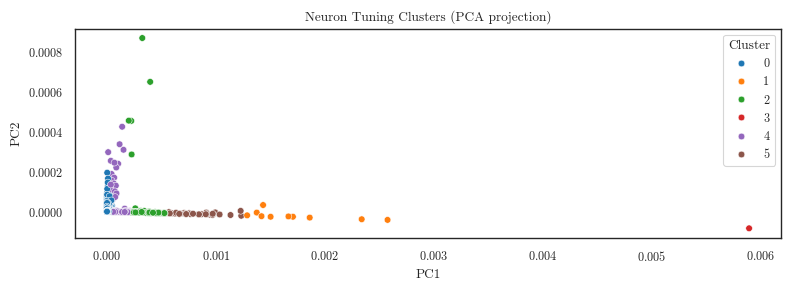

In [254]:
fig, ax = plt.subplots(figsize=(8,3))
sns.scatterplot(x=nef_pca[:, 0], y=nef_pca[:, 1], hue=nef_tuning['cluster'], palette=palette, ax=ax)
ax.set(xlabel='PC1', ylabel='PC2', title='Neuron Tuning Clusters (PCA projection)')
ax.legend(title='Cluster')
fig.tight_layout()
fig.savefig("plots/nef_clustering.jpg", dpi=600)

/tmp/ipykernel_1314961/4102846526.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/4102846526.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/4102846526.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/4102846526.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/4102846526.py:6: UserWarning: set_ticklab

[Text(0, 0.5, 'Regression Weight')]

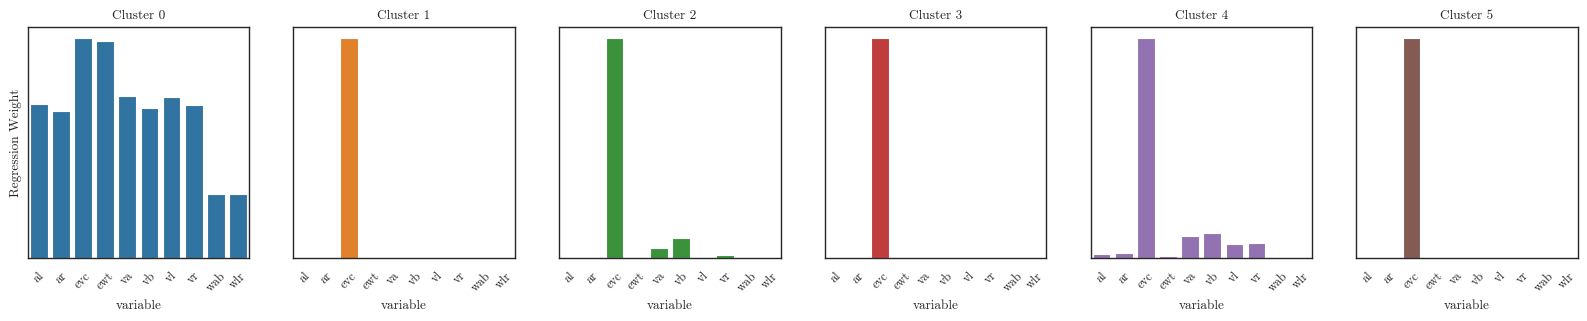

In [255]:
cluster_means = nef_tuning.drop(columns=['cluster', 'dominant_variable']).groupby(nef_tuning['cluster']).mean()
n_clusters = cluster_means.shape[0]
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(20,3), sharey=False)
for i in range(n_clusters):
    sns.barplot(cluster_means.loc[i], color=palette[i], ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set(title=f"Cluster {i}", ylabel=None, yticks=[])
axes[0].set(ylabel='Regression Weight')

In [244]:
monkey_weights = pd.read_pickle("data/monkey_regression_weights.pkl")
monkey_pca, monkey_tuning = cluster_weights(monkey_weights, n_clusters=6)

/tmp/ipykernel_1314961/296432271.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=monkey_pca[:, 0], y=monkey_pca[:, 1], hue=monkey_tuning['cluster'], palette=palette, ax=ax)


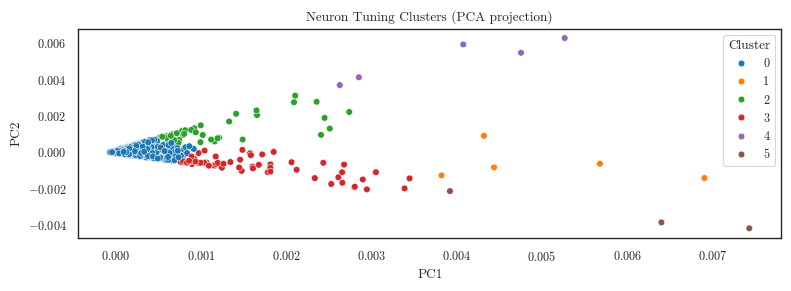

In [252]:
fig, ax = plt.subplots(figsize=(8,3))
sns.scatterplot(x=monkey_pca[:, 0], y=monkey_pca[:, 1], hue=monkey_tuning['cluster'], palette=palette, ax=ax)
ax.set(xlabel='PC1', ylabel='PC2', title='Neuron Tuning Clusters (PCA projection)')
ax.legend(title='Cluster')
fig.tight_layout()
fig.savefig("plots/monkey_clustering.jpg", dpi=600)

/tmp/ipykernel_1314961/154235846.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=monkey_pca[:, 0], y=monkey_pca[:, 1], hue=monkey_tuning['cluster'], palette=palette, ax=ax)
/tmp/ipykernel_1314961/154235846.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/154235846.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/154235846.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_1314961/154235846.py:13: UserWarning:

[Text(0, 0.5, 'Regression Weight')]

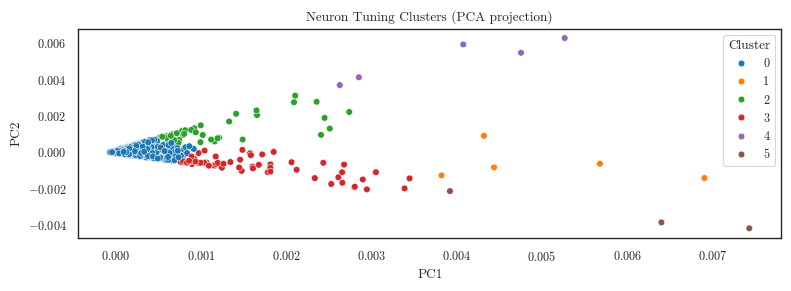

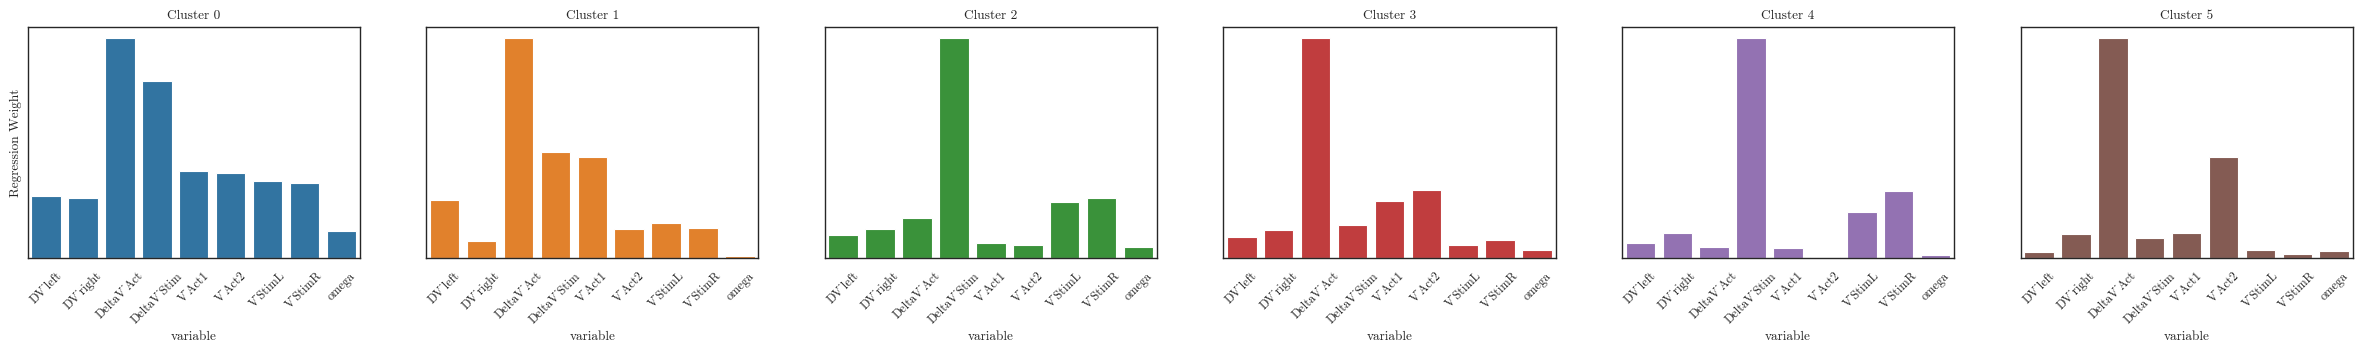

In [ ]:
cluster_means = monkey_tuning.drop(columns=['cluster', 'dominant_variable']).groupby(monkey_tuning['cluster']).mean()
n_clusters = cluster_means.shape[0]
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(30,3), sharey=False)
for i in range(n_clusters):
    sns.barplot(cluster_means.loc[i], color=palette[i], ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set(title=f"Cluster {i}", ylabel=None, yticks=[])
axes[0].set(ylabel='Regression Weight')